## Inital setup

In [1]:
# PyTorch model and training necessities
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import irtorch.load_dataset as load_dataset
import irtorch.models as models
from irtorch import IRT

torch.set_printoptions(precision=7, sci_mode=False)
device = "cuda"
device = "cpu"
latent_variables = 2
one_hot_encoded = True
negative_latent_variable_item_relationships = True

INFO: Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


## Load data

In [2]:
data = load_dataset.big_five()
data = data[~data.isnan().any(dim=1)]
n_cats = [int(data[:, col].max()) + 1 for col in range(data.shape[1])]
mc_correct = None
train_data = data[:10000, :]
test_data = data[10000:, :]

In [3]:
data = load_dataset.swedish_national_mathematics_2018()
data = load_dataset.swedish_national_mathematics_2019()
n_cats = [int(data[:, col].max()) + 1 for col in range(data.shape[1])]
mc_correct = None
writer = SummaryWriter('runs/natmath')
train_data = data
test_data = None
model_missing = True

In [4]:
data = load_dataset.swedish_sat_2022_binary()[:, :80]
data, mc_correct = load_dataset.swedish_sat_2022()
data, mc_correct = load_dataset.swedish_sat_verbal_2022()
data, mc_correct = load_dataset.swedish_sat_quantitative_2022()
writer = SummaryWriter('runs/swesat')
n_cats = (torch.where(~data.isnan(), data, torch.tensor(float('-inf'))).max(dim=0).values + 1).int().tolist()
train_data = data[:5000, :]
test_data = data[5000:, :]
# model_missing = True
model_missing = False
train_data = train_data[~train_data.isnan().any(dim=1)]
test_data = test_data[~test_data.isnan().any(dim=1)]

In [5]:
# Only 20 items
# train_data = train_data[:, :20]
# test_data = test_data[:, :20]
# n_cats = n_cats[:20]
# mc_correct = mc_correct[:20]

In [6]:
# Sample 80% of data for training, 20% for testing
# torch.manual_seed(125)
# total_size  = data.shape[0]
# train_size = int(total_size * 0.8)
# test_size = total_size - train_size
# indices = torch.randperm(total_size)
# train_data = data[:train_size]
# test_data = data[train_size:]

## Autoencoder

In [7]:
torch.manual_seed(42) # For reproducibility purposes

In [8]:
irt_model = models.Parametric(latent_variables=latent_variables, item_categories=n_cats, model = "GPC")
irt_model = models.Parametric(latent_variables=latent_variables, item_categories=n_cats, model = "nominal", mc_correct=mc_correct)

In [9]:
separate = "items"
separate = "categories"
# decoder_ae = models.NonparametricMonotone(
#     latent_variables=latent_variables, 
#     item_categories=n_cats, 
#     hidden_dim=[2]*4, 
#     mc_correct=mc_correct,
#     separate=separate,
#     negative_latent_variable_item_relationships=negative_latent_variable_item_relationships,
#     use_bounded_activation=False,
# )
model = models.NonparametricMonotoneNN(
    latent_variables=latent_variables, 
    item_categories=n_cats, 
    hidden_dim=[3]*1, 
    model_missing=model_missing,
    mc_correct=mc_correct,
    separate=separate,
    negative_latent_variable_item_relationships=negative_latent_variable_item_relationships,
    use_bounded_activation=True,
)

In [10]:
ae_model = IRT(
    model = "MMCNN",
    estimation_algorithm="AE",
    latent_variables=latent_variables,
    item_categories=n_cats,
    model_missing=model_missing,
    mc_correct=mc_correct,
    one_hot_encoded=one_hot_encoded
)

In [11]:
ae_model.fit(
    train_data=train_data,
    validation_data=None,
    batch_size=64,
    max_epochs=500,
    learning_rate=0.04,
    learning_rate_update_patience=4,
    learning_rate_updates_before_stopping=5,
    device=device,
)

Epoch: 15. Average training batch loss function: 71.2905 

KeyboardInterrupt: 

In [12]:
# ae_model.load_model("models/ae_model2d.pt")
# ae_model.save_model("models/ae_model_big_five.pt")
# ae_model.save_model("models/ae_1layer_mmc_2d.pt")
ae_model.load_model("models/ae_1layer_mmc_2d.pt")
# ae_model.save_model("models/ae_1layer_mmc.pt")
# ae_model.load_model("models/ae_1layer_mmc.pt")

INFO: NN estimation of z scores.
INFO: Using traning data z scores as population z scores for bit score computation.
INFO: Approximating minimum bit score z from random guessing data for latent variable 1.
INFO: NN estimation of z scores.
INFO: Approximating minimum bit score z from random guessing data for latent variable 2.
INFO: NN estimation of z scores.


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Latent variable density plot'}, xlabel='Latent variable', ylabel='Density'>)

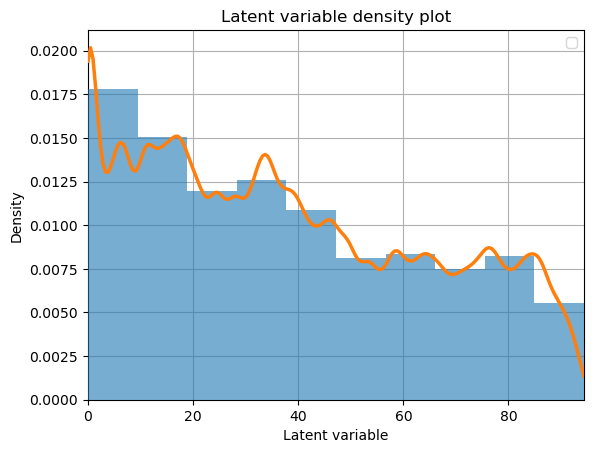

In [21]:
ae_model.plot_latent_score_distribution(kernel_bandwidth=1.4, scale = "bit", z_estimation_method = "NN")

In [ ]:
theta = ae_model.latent_scores(train_data)

In [ ]:
z_test = ae_model.latent_scores(test_data, scale="z", z_estimation_method="NN")
z_train = ae_model.latent_scores(train_data, scale="z", z_estimation_method="NN")

In [ ]:
g1 = ae_model.model.information(z_test[:4], item=False)
print(g1.shape)

In [ ]:
g1 = ae_model.model.probability_gradients(z_test[:10])
g1.shape

In [ ]:
z_test = ae_model.latent_scores(test_data, scale="z", z_estimation_method="ML", ml_map_device="cuda")

In [ ]:
ae_model.log_likelihood(test_data, z_test)

# Residuals

In [ ]:
residuals = ae_model.residuals(test_data, z_test, average_per="none")
group_residuals_std, group_means_std = ae_model.evaluator.group_fit_residuals(train_data, z_train)
group_residuals, group_means = ae_model.evaluator.group_fit_residuals(train_data, z_train, standardize=False)

In [ ]:
print(group_residuals_std[:, :, 1:][~group_residuals_std[:, :, 1:].isnan()].min())
print(group_residuals[:, :, 1:][~group_residuals[:, :, 1:].isnan()].min())
print(group_residuals_std[:, :, 1:][~group_residuals_std[:, :, 1:].isnan()].max())
print(group_residuals[:, :, 1:][~group_residuals[:, :, 1:].isnan()].max())

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.histplot(residuals.view(-1)[0:1000].numpy(), bins=20, kde=True, color='black')
plt.show()

In [ ]:
sns.histplot(group_residuals.view(-1)[0:1000].numpy(), bins=20, kde=True, color='black')
plt.show()

In [ ]:
sns.histplot(group_residuals_std.view(-1)[0:1000].numpy(), bins=20, kde=True, color='black')
plt.show()

In [ ]:
abs_residuals = group_residuals.abs().nanmean(dim=(1, 2)).numpy()
print(abs_residuals) # average per group
sns.scatterplot(x=range(len(abs_residuals)), y=abs_residuals, color='black')
plt.show()

# Log likelihood

In [ ]:
import matplotlib.pyplot as plt
test_taker = 3
z_range = torch.arange(-20, 20, 0.01).reshape(-1, 1)
z_range_data = test_data[test_taker].repeat(z_range.shape[0], 1)
z_range_lls = ae_model.log_likelihood(z_range_data, z=z_range, reduction="sum", level = "respondent")
plt.plot(z_range.view(-1).numpy(), z_range_lls.numpy())
# ae_model.latent_scores(test_data[test_taker], scale = "z", z_estimation_method="ML", lbfgs_learning_rate = 0.1)
# ae_model.latent_scores(test_data[test_taker], scale = "z", z_estimation_method="NN")

In [ ]:
z_scores = ae_model.latent_scores(test_data, scale = "z", z_estimation_method="ML", lbfgs_learning_rate = 0.5)
z_scoresnn = ae_model.latent_scores(test_data, scale = "z", z_estimation_method="NN")
print(ae_model.log_likelihood(test_data, z=z_scores, reduction="sum"))
print(ae_model.log_likelihood(test_data, z=z_scoresnn, reduction="sum"))
v1 = ae_model.log_likelihood(test_data, z=z_scores, reduction="sum", level = "respondent")
v3 = ae_model.log_likelihood(test_data, z=z_scoresnn, reduction="sum", level = "respondent")
print((v1-v3 > 0).sum())
v1.shape

In [ ]:
ae_model.plot_item_probabilities(1, scale="entropy", bit_score_z_grid_method="NN")

In [ ]:
print(ae_model.log_likelihood(test_data, z_estimation_method="ML")/test_data.shape[0])
print(ae_model.log_likelihood(test_data, z_estimation_method="NN")/test_data.shape[0])

In [ ]:
print(ae_model.performance_measures(train_data, z_estimation_method="NN"))
print(ae_model.performance_measures(train_data, z_estimation_method="ML"))

In [ ]:
# print(torch.all(ae_model.neuralnet.decoder.negation_dim0.all_item_weights().sign() == ae_model.expected_item_score_slopes().sign()[:, 0]))
loading_matrix = ae_model.expected_item_score_slopes()

In [ ]:
from factor_analyzer import Rotator
fig, ax = ae_model.plot_item_latent_variable_relationships(loading_matrix)
fig.set_size_inches(14, 8)
rotator = Rotator(method = "oblimin")
rotator = Rotator(method = "geomin_obl")
rot_loadings = torch.from_numpy(rotator.fit_transform(loading_matrix)).float()
fig, ax = ae_model.plot_item_latent_variable_relationships(rot_loadings)
fig.set_size_inches(14, 8)
print(torch.matmul(torch.pinverse(loading_matrix), loading_matrix)) # inverse seems okay
rotation_matrix = torch.matmul(torch.pinverse(loading_matrix), rot_loadings) # this is the approximated rotation matrix
torch.matmul(ae_model.neuralnet.training_z_scores[:4, :], rotation_matrix) # scores on rotated latent variables

In [ ]:
loading_matrix[34:35, :].abs().mean(dim=0)
print(loading_matrix[30:36, 1:])

In [ ]:
# it seems we can learn the relationship with categories, but not the positve relationship with items or none
print(ae_model.neuralnet.decoder.negation_dim0.weight_param)

In [ ]:
# set to mirt natmat19 parameters. Now we get the same results as mirt. Thus we know ML works
ae_model.neuralnet.decoder.weight_param.data = torch.tensor([2.5189051, 1.0967695, 1.7912886, 1.0544961, 1.3236270, 0.7682886, 1.1903453, 1.1976377, 1.0403539, 1.1382457, 1.1452582, 1.6043902, 1.5123447, 1.1255488, 1.5347988, 0.8174907, 1.2528523, 1.5601218, 1.5662433, 1.4421894, 1.5873562, 1.1329438, 1.0850653, 1.8991486, 0.6878224, 2.8491980, 1.3779171, 1.3775168])
ae_model.neuralnet.decoder.bias_param.data = torch.tensor([5.93121597, 1.11018681, 2.67522172, 0.65849740, 0.12171197, 0.63857422, -0.28117063, 2.52399358, 0.08670245, -0.26579335, 0.32917236, 0.23361287, 0.81169356, 2.06087681, 0.95423703, -0.96461046, 1.81968773, 2.30483187, -1.16145291, -0.74049082, -1.72369722, -0.33545562, -4.36504949, 0.29119501, 0.72781671, 0.64072305, 1.24324280, -1.14788551, -1.01538586, 0.36050509, 0.42816877, -0.06657620, -1.46316508, -3.31066712, -3.42984958, -5.50889103, -6.73668716, -7.40374796, 2.45505041, 3.34499460, 0.50128754, 2.15389234, 0.79753226, 0.28523457, -0.12389297, -2.67341152, -0.32989097, -0.66872235, -0.74760225, -0.46646419, -3.83190003, -7.28969035, -2.64948762, -3.77082790, -3.05549163, -5.52320448, -6.80493089, -8.49903333])
print(ae_model.neuralnet.decoder.item_probabilities(torch.tensor([[0.5]]))[:, 9, :])
print(ae_model.performance_measures(train_data, z_estimation_method="ML"))

## Furter improve decoder

In [ ]:
old_decoder = ae_model.neuralnet.decoder

In [ ]:
new_decoder = models.Parametric(latent_variables=latent_variables, item_categories=n_cats, model = "gpc")
new_decoder = models.NonparametricMonotone(
    latent_variables=latent_variables, 
    item_categories=n_cats, 
    hidden_dim=[6, 6, 6, 6], 
    mc_correct=mc_correct,
    negative_latent_variable_item_relationships=negative_latent_variable_item_relationships,
    use_bounded_activation=False,
)

In [ ]:
z_scores = ae_model.latent_scores(train_data, "z", "ML")
torch_data = torch.utils.data.TensorDataset(torch.cat((z_scores, train_data), dim=1))
torch_loader = torch.utils.data.DataLoader(torch_data, batch_size=64, shuffle=True)

In [ ]:
optimizer = torch.optim.Adam(new_decoder.parameters(), lr=0.002)
# Reduce learning rate when loss stops decreasing ("min")
# we multiply the learning rate by the factor
# patience: We need to improvement after 3 epochs for it to trigger
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, verbose=True
)

In [ ]:
new_decoder.train()
for epoch in range(400):
    total_loss = 0
    for _, batch in enumerate(torch_loader):
        optimizer.zero_grad()
        logits = new_decoder(batch[0][:, z_scores.shape[1]-1].view(-1, 1))
        loss = -new_decoder.log_likelihood(batch[0][:, z_scores.shape[1]:], logits) / data.shape[0]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"epoch: {epoch}, loss: {total_loss}")

ae_model.neuralnet.decoder = new_decoder

In [ ]:
# print(ae_model.performance_measures(test_data))
print(ae_model.performance_measures(train_data, z_estimation_method="NN"))
print(ae_model.performance_measures(train_data, z_estimation_method="ML"))

## Visualize the z - output relationships

In [ ]:
ae_model.plot_latent_score_distribution(train_data, z_estimation_method="NN")

In [ ]:
input_z = torch.arange(-40, 40, 0.1).unsqueeze(1)
outputs = ae_model.neuralnet.decoder(input_z)
print(outputs.shape)
import matplotlib.pyplot as plt
for item, max_cats in enumerate([max(n_cats)]*len(n_cats)):
    plt.plot(input_z.detach().numpy(), outputs[:, item*max_cats:(item*max_cats+n_cats[item])].detach().numpy())
    plt.title(f"Item {item+1}")
    plt.show()

In [ ]:
# ae_model.plot_item_probabilities(2, scale = "z", plot_group_fit=True, group_fit_groups=10, group_z_estimation_method="ML")
ae_model.plot_item_probabilities(55, scale = "entropy")
# ae_model.plot_item_probabilities(55, scale = "z", plot_group_fit=True, group_fit_groups=10, group_z_estimation_method="NN")

In [ ]:
for item in range(1, 20):
    ae_model.plot_item_probabilities(item, scale = "z", plot_group_fit=True, group_fit_groups=10, group_z_estimation_method="NN")

## Evaluating gradients etc..

In [ ]:
ae_model.neuralnet.decoder(input)

In [ ]:
# TODO Does not seem to work...
from captum.attr import IntegratedGradients, LayerConductance, NeuronConductance

In [ ]:
# Feature attribution
input = torch.tensor([[0.2]], dtype=torch.float)
ig = IntegratedGradients(ae_model.neuralnet.decoder)
# Target is logit column index in output.
attributions, delta = ig.attribute(input, target=1, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

In [ ]:
# Layer attribution for single layer
lc = LayerConductance(ae_model.neuralnet.decoder, ae_model.neuralnet.decoder.linear0_dim0)
lc = LayerConductance(ae_model.neuralnet.decoder, ae_model.neuralnet.decoder.linear_out_dim0)
layer_attributions = lc.attribute(input, target=6)
layer_attributions

In [ ]:
# Choose a neuron index in the layer
nc = NeuronConductance(ae_model.neuralnet.decoder, ae_model.neuralnet.decoder.linear_out_dim0)
neuron_attributions = nc.attribute(input, target=6, neuron_selector=6)
neuron_attributions

In [ ]:
# Feature attribution using deep lift
from captum.attr import DeepLift
deep_lift = DeepLift(ae_model.neuralnet.decoder)
# Compute the attribution for a specific class
attribution = deep_lift.attribute(torch.tensor([[0.1]]), target=1)
# The 'attribution' tensor now holds the importance of each feature in 'sample_input'
attribution

In [ ]:
import shutil
import os 
if os.path.exists("runs/parameters"):
    shutil.rmtree("runs/parameters")

In [ ]:
ae_model.fit(
    train_data=train_data,
    validation_data=test_data,
    batch_size=32,
    epochs=8,
    learning_rate=0.02,
    device=device,
    verbose=False
)

In [ ]:
torch.set_printoptions(precision=4, sci_mode=False)
layer = ae_model.neuralnet.decoder.linear_out_dim0
weights = layer.raw_weight_param
weights = F.softmax(weights)
weights
weights.min()

Monitor both CPU and GPU and record tensor shapes

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_training"):
        ae_model.fit(
            train_data=train_data,
            validation_data=test_data,
            batch_size=32,
            epochs=3,
            learning_rate=0.02,
            device=device,
            verbose=False
        )


In [ ]:
prof_result = prof.key_averages(group_by_input_shape=True)

In [ ]:
prof_result

In [ ]:
print(prof_result.table(sort_by="cuda_time_total", row_limit=None))

## Visualizing the model
add_graph() will trace the sample input through your model,
and render it as a graph.

In [ ]:
writer.add_graph(ae_model.neuralnet, train_data)
writer.flush()

When you switch over to TensorBoard, you should see a GRAPHS tab. Double-click the nodes to see the layers and data flow within the model.